# Analyse de données de films

Nous proposons de travailler sur des données décrivant des films. Les possibilités sont larges et vous êtes évalués sur vos propositions et votre méthodologie plus que sur vos résultats.

Les données de départ sont disponibles sur:
https://grouplens.org/datasets/movielens/
au format CSV. 

Nous nous intéresserons en particulier au jeu de données: **MovieLens 20M Dataset**. Dans ce jeu de données, vous disposez entre autre de:
* Idendifiant du film dans IMdb et TMdb (ça sera important ensuite)
* Catégorie(s) du film
* Titre du film
* Notes données par les internautes aux films

Afin de rendre le projet plus intéressant, nous ajoutons des données sur les acteurs et producteurs associés aux films (récupéré sur TMdb). Ces données sont disponibles sur les liens suivants:

http://webia.lip6.fr/~guigue/film_v2.pkl <br>
http://webia.lip6.fr/~guigue/act_v2.pkl <br>
http://webia.lip6.fr/~guigue/crew_v2.pkl

Ces fichiers contiennent respectivement : une nouvelle description des films (dont l'identifiant TMdb et la note moyenne donnée par les internautes, la date de sortie,...), une description des acteurs de chaque film et une description des équipes (scénariste, producteur, metteur en scène) pour chaque film.

Ces données sont des listes de taille 26908, chaque élément de la liste correspondant à un dictionnaire dont vous étudierez les clés pour récupérer les informations utiles.

**ATTENTION** Les contraintes de récupération d'informations en ligne font que la base MovieLens compte 27278 films mais les fichiers ci-dessus n'en comptent que 26908. Le plus simple est probablement d'éliminer les films de MovieLens qui ne sont pas dans cette seconde base.

## Consignes générales pour l'analyse des données

Vous devez proposer plusieurs analyses des données, qui devront à minima utiliser les
 techniques suivantes:
 
1. Mettre en forme les données pour identifier les acteurs et les catégories, les indexer
1. Traiter au moins un problème de régression supervisé (par exemple la prédiction de la note moyenne donnée à un film par les internautes).
1. Traiter au moins un problème de classification supervisé (par exemple la prédiction de la catégorie d'un film)
1. Utiliser les données catégorielles (catégories, acteurs,...) de manière discrète ET de manière coninue (*dummy coding*) dans des approches différentes
1. Proposer au moins une approche de catégorisation non supervisée (pour regrouper les acteurs par exemple)
1. Mener une campagne d'expérience permettant de comparer les performances sur un problème en fonction des valeurs d'un paramètre (et donc, in fine, trouver la meilleure valeur du paramètre)
1. Proposer quelques illustrations

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle as pkl
import math
import random
# La ligne suivante permet de préciser le chemin d'accès à la librairie iads
import sys
sys.path.append('../')



# Importation de la librairie iads
import iads as iads

# importation de LabeledSet
from iads import LabeledSet as ls

# importation de Classifiers
from iads import Classifiers as cl

from iads import utils as ut

from iads import kmoyennes as km

from sklearn.cluster import KMeans


## Chargement des données (base MovieLens + enrichissements)

In [5]:
# Chargement des données MovieLens
fname_links = "data/ratings.csv"
ratings = pd.read_csv(fname_links, encoding='utf8')

fname_links = "data/movies.csv"
movies_set = pd.read_csv(fname_links, encoding='utf8')

fname_links = "data/moviesFiltree.csv"
movies = pd.read_csv(fname_links, encoding='utf8', index_col=0)

fname_links = "data/links.csv"
links = pd.read_csv(fname_links, encoding='utf8')

fname_links = "data/tags.csv"
tags = pd.read_csv(fname_links, encoding='utf8')

#fname_links = "data/genome-tags.csv"
#genome-tags = pd.read_csv(fname_links, encoding='utf8')

#fname_links = "data/genome-scores.csv"
#genome-scores = pd.read_csv(fname_links, encoding='utf8')"""

In [6]:
# Chargement des données complémentaires
fname = "data/act_v2.pkl"
acteurs = pkl.load(open(fname, "rb"))

fname = "data/film_v2.pkl"
films = pkl.load(open(fname, "rb"))

fname = "data/crew_v2.pkl"
crew = pkl.load(open(fname, "rb"))

In [4]:
"""
#Eliminer les films de MovieLens qui ne sont pas dans la base complémentaire
print("BEFORE")
print(len(movies))
moviesFilter = []
filmId = []
cpt = 0
for i in range(len(films)):
    filmId.append(films[i]["id"])
    
for i in range(len(movies)):
    line = links.loc[links['movieId'] == movies.iloc[i]["movieId"]]
    value = float(line.iloc[0]["tmdbId"])
    if(math.isnan(value)):
        cpt += 1
        continue
    if(value in filmId):
        moviesFilter.append(movies.iloc[i]["movieId"])
    else:
        cpt += 1
movies = movies[movies.movieId.isin(moviesFilter)]
links = links[links.movieId.isin(moviesFilter)]
ratings = ratings[ratings.movieId.isin(moviesFilter)]
print("\nAFTER")
print(len(movies))
movies.to_csv("data/moviesFiltree.csv", encoding='utf8')
"""

'\n#Eliminer les films de MovieLens qui ne sont pas dans la base complémentaire\nprint("BEFORE")\nprint(len(movies))\nmoviesFilter = []\nfilmId = []\ncpt = 0\nfor i in range(len(films)):\n    filmId.append(films[i]["id"])\n    \nfor i in range(len(movies)):\n    line = links.loc[links[\'movieId\'] == movies.iloc[i]["movieId"]]\n    value = float(line.iloc[0]["tmdbId"])\n    if(math.isnan(value)):\n        cpt += 1\n        continue\n    if(value in filmId):\n        moviesFilter.append(movies.iloc[i]["movieId"])\n    else:\n        cpt += 1\nmovies = movies[movies.movieId.isin(moviesFilter)]\nlinks = links[links.movieId.isin(moviesFilter)]\nratings = ratings[ratings.movieId.isin(moviesFilter)]\nprint("\nAFTER")\nprint(len(movies))\nmovies.to_csv("data/moviesFiltree.csv", encoding=\'utf8\')\n'

## Feature engineering
A vous de créer les caractéristiques de description des données qui permettront d'améliorer les performances dans les tâches que vous aurez choisi d'aborder dans le projet.

In [7]:
# Faire un dictionnaire avec tous les acteurs (acteur => indice)
# + un dictionnaire inversé (indice => acteur)
actors = dict()
actors_inv = dict()
for lista in acteurs:
    for a in lista:
        # affecte une valeur à une clé si la clé n'est pas utilisée
        res = actors.setdefault(a['name'], len(actors))
        if res == len(actors)-1:
            actors_inv[len(actors)-1] = a['name']

# Exemple de transformation supplémentaire
# Dans combien de films de base joue Tom Hanks? (Réponse 57)
# Dans combien de comédies...

# => On voit qu'il est possible de créer facilement des nouvelles caractéristiques qui
# apporteront des informations utiles pour certaines tâches

In [8]:
len(actors)

162910

In [9]:
"Tom London" in actors.keys()

True

In [10]:
dict(list(actors.items())[0:20])

{'Tom Hanks': 0,
 'Tim Allen': 1,
 'Don Rickles': 2,
 'Jim Varney': 3,
 'Wallace Shawn': 4,
 'John Ratzenberger': 5,
 'Annie Potts': 6,
 'John Morris': 7,
 'Erik von Detten': 8,
 'Laurie Metcalf': 9,
 'R. Lee Ermey': 10,
 'Sarah Freeman': 11,
 'Penn Jillette': 12,
 'Sherry Lynn': 13,
 'Jack Angel': 14,
 'Spencer Aste': 15,
 'Greg Berg': 16,
 'Lisa Bradley': 17,
 'Kendall Cunningham': 18,
 'Debi Derryberry': 19}

In [11]:
movies.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [12]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [13]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [14]:
films_set = pd.DataFrame(films)
films_set.drop(columns=["backdrop_path","poster_path"] , inplace=True)
films_set.head()

,adult,genre_ids,id,original_language,original_title,overview,popularity,release_date,title,video,vote_average,vote_count
0,False,"[16, 35, 10751]",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",22.773,1995-10-30,Toy Story,False,7.9,9550
1,False,"[12, 14, 10751]",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,2.947,1995-12-15,Jumanji,False,7.1,5594
2,False,"[35, 10749]",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,6.076,1995-12-22,Grumpier Old Men,False,6.5,140
3,False,"[35, 18, 10749]",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",2.917,1995-12-22,Waiting to Exhale,False,6.1,55
4,False,[35],11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,6.817,1995-02-10,Father of the Bride Part II,False,6.1,288


In [15]:
#On crée un DataFrame reliant les deux bases de données de Movielens
rate_by_movie = pd.merge(ratings, movies)
rate_by_movie.head()

,userId,movieId,rating,timestamp,title,genres
0,1,2,3.5,1112486027,Jumanji (1995),Adventure|Children|Fantasy
1,5,2,3.0,851527569,Jumanji (1995),Adventure|Children|Fantasy
2,13,2,3.0,849082742,Jumanji (1995),Adventure|Children|Fantasy
3,29,2,3.0,835562174,Jumanji (1995),Adventure|Children|Fantasy
4,34,2,3.0,846509384,Jumanji (1995),Adventure|Children|Fantasy


In [16]:
#Quels sont les films qui ont été les plus notés ?
ratings_count_by_movie = rate_by_movie.groupby("title").size().sort_values(ascending=False)
ratings_count_by_movie.head()

title
Pulp Fiction (1994)                 67310
Forrest Gump (1994)                 66172
Shawshank Redemption, The (1994)    63366
Silence of the Lambs, The (1991)    63299
Jurassic Park (1993)                59715
dtype: int64

In [17]:
#Quelle est la moyenne pour chaque film ?
mean_by_movie = rate_by_movie.groupby('title').agg({'rating': np.mean}).sort_values(by="rating", ascending=False)
mean_by_movie.head()

,rating
title,
The Encounter (2010),5.0
Afstiros katallilo (2008),5.0
Catastroika (2012),5.0
Stealing a Nation (2004),5.0
Central Park (1991),5.0


Text(0.5, 1.0, 'Fréquence des films en fonction de la moyenne')

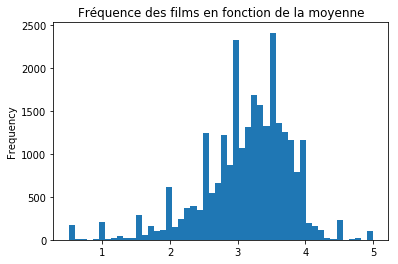

In [54]:
mean_by_movie.rating.plot.hist(bins=50)
plt.title('Fréquence des films en fonction de la moyenne')

In [19]:
#Quelle est la moyenne pour les films ayant eu plus de 50 avis ?
mean_by_famous_movie = mean_by_movie[ratings_count_by_movie>50].sort_values(by='rating', ascending=False)
mean_by_famous_movie.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,rating
title,
"Shawshank Redemption, The (1994)",4.446990
"Godfather, The (1972)",4.364732
"Usual Suspects, The (1995)",4.334372
Schindler's List (1993),4.310175
"Godfather: Part II, The (1974)",4.275641


Text(0.5, 1.0, 'Fréquence des films populaires en fonction de la moyenne')

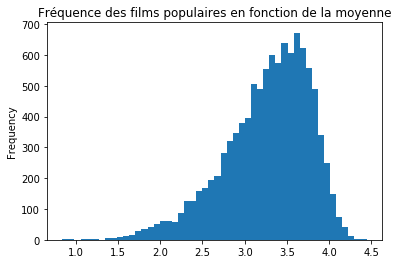

In [55]:
mean_by_famous_movie.rating.plot.hist(bins=50)
plt.title('Fréquence des films populaires en fonction de la moyenne')

In [21]:
movie_rate_genre = mean_by_famous_movie.merge(movies, on="title")
movie_rate_genre.head()

,title,rating,movieId,genres
0,"Shawshank Redemption, The (1994)",4.446990,318,Crime|Drama
1,"Godfather, The (1972)",4.364732,858,Crime|Drama
2,"Usual Suspects, The (1995)",4.334372,50,Crime|Mystery|Thriller
3,Schindler's List (1993),4.310175,527,Drama|War
4,"Godfather: Part II, The (1974)",4.275641,1221,Crime|Drama


In [22]:
#On regarde les différents genres
each_genre = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
each_genre

array(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Mystery', 'Sci-Fi', 'IMAX', 'Documentary', 'War', 'Musical',
       'Western', 'Film-Noir', '(no genres listed)'], dtype=object)

In [23]:
#Chaque film selon si il appartient à une ou plusieurs des 20 catégories avec sa moyenne
movies_dummies = movie_rate_genre.join(movie_rate_genre.genres.str.get_dummies().astype(int))
movies_dummies.drop('genres', inplace=True, axis=1)
movies_dummies.head()

,title,rating,movieId,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,"Shawshank Redemption, The (1994)",4.446990,318,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,"Godfather, The (1972)",4.364732,858,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,"Usual Suspects, The (1995)",4.334372,50,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
3,Schindler's List (1993),4.310175,527,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,"Godfather: Part II, The (1974)",4.275641,1221,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
clapd = mean_by_movie.merge(movies, on="title")
clapd.head()

,title,rating,movieId,genres
0,The Encounter (2010),5.0,126397,Children|Drama
1,Afstiros katallilo (2008),5.0,129243,Comedy
2,Catastroika (2012),5.0,108527,Documentary
3,Stealing a Nation (2004),5.0,105529,Documentary
4,Central Park (1991),5.0,101188,Documentary


## Classification

Regarder si un film est sorti au 20eme ou 21eme siecle en fonction de si le film est un Western ou un IMAX et du nombre d'acteur qui joue dans ce film

In [25]:
movies_dummies_cla = clapd.join(clapd.genres.str.get_dummies().astype(int))
movies_dummies_cla.drop('genres', inplace=True, axis=1)
movies_dummies_cla.head()

,title,rating,movieId,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,The Encounter (2010),5.0,126397,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Afstiros katallilo (2008),5.0,129243,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,Catastroika (2012),5.0,108527,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Stealing a Nation (2004),5.0,105529,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Central Park (1991),5.0,101188,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
movies_dummies_cla['year'] = movies_dummies_cla.title.str.extract("\((\d{4})\)", expand=True)
movies_dummies_cla.year = pd.to_datetime(movies_dummies_cla.year, format='%Y')
movies_dummies_cla.year = movies_dummies_cla.year.dt.year
movies_dummies_cla.title = movies_dummies_cla.title.str[:-7]

In [27]:
movies_dummies_cla[['title','rating','movieId', "Western", "IMAX", "year"]].sort_values("movieId").head()

,title,rating,movieId,Western,IMAX,year
1982,Toy Story,3.921240,1,0,0,1995.0
13357,Jumanji,3.211977,2,0,0,1995.0
14270,Grumpier Old Men,3.151040,3,0,0,1995.0
18990,Waiting to Exhale,2.861393,4,0,0,1995.0
15514,Father of the Bride Part II,3.064592,5,0,0,1995.0


In [28]:
acteurs_dans_film = dict()
tous_les_acteurs = set()
for index,row in movies_set.iloc[:(len(acteurs)//5)].iterrows():
    liste_acteurs = list()
    for i in acteurs[index]:
        liste_acteurs.append(i['name'])
        tous_les_acteurs.add(i['name'])
    acteurs_dans_film[row["movieId"]] = liste_acteurs

In [59]:
labset = ls.LabeledSet(3)
for key in acteurs_dans_film.keys():
    listeligne=list()
    row = movies_dummies_cla.loc[movies_dummies_cla["movieId"]==key][['rating', "Western", "IMAX"]]
    if len(row)==0:
        continue
    if movies_dummies_cla.loc[movies_dummies_cla["movieId"]==key]["year"].values[0]>=2000:
        label = 1
    else :
        label =-1
    for i in row.values[0]:
        listeligne.append(i)
    listeligne.append(len(acteurs_dans_film[key]))
    labset.addExample(listeligne, label)

    

In [68]:
kernel = ut.KernelPolynomial()
cns = cl.ClassifierPerceptronKernelNonStock(len(kernel.transform(labset.getX(0))), 0.0001, kernel)
train, test = ut.split(0.6, labset)

Text(0.5, 0, "nombre d'itérations")

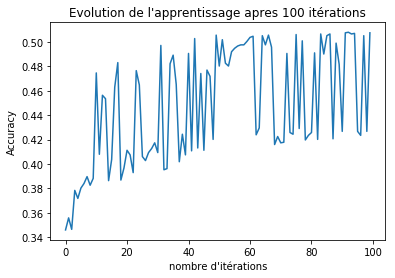

In [69]:
accuracy=list()
for i in range(100):
    cns.train(train,100)
    accuracy.append(cns.accuracy(test))
    
plt.plot([i for i in range(100)],accuracy)
plt.title('Evolution de l\'apprentissage apres 100 itérations')
plt.ylabel("Accuracy")
plt.xlabel("nombre d'itérations")

In [70]:
print(cns.accuracy(test))

0.5075117370892018


### Regression

Regression pour prédire la note du film en fonction de sa catégorie

In [18]:
lab = ls.LabeledSet(19)
for index, row in movies_dummies.iterrows():
    ligne = row[3:]
    lab.addExample(np.array(ligne), row["rating"])

In [19]:
for i in range(15):
    print(lab.getX(i), lab.getY(i))

[0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0] [4.4469905]
[0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0] [4.3647322]
[0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0] [4.33437221]
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0] [4.31017501]
[0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0] [4.27564056]
[1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0] [4.27417966]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0] [4.2713336]
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0] [4.25832683]
[0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0] [4.25693487]
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0] [4.24807898]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0] [4.24728682]
[0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0] [4.24600152]
[1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0] [4.23541006]
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0] [4.23479021]
[1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0] [4.23353811]


In [342]:
kernel = ut.KernelPolynomial()
cmc = cl.ClassifierMoindreCarres(len(kernel.transform(lab.getX(0))), 0.0005, kernel)
train, test = split(0.6, lab)

Text(0, 0.5, 'Accuracy')

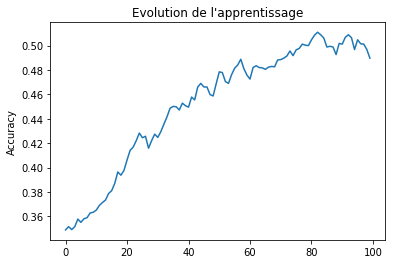

In [343]:
accuracy=list()
for i in range(100):
    cmc.train(train,100)
    accuracy.append(cmc.accuracy(test))
    
plt.plot([i for i in range(100)],accuracy)
plt.title('Evolution de l\'apprentissage')
plt.ylabel("Accuracy")
plt.xlabel("nombre d'itérations")

In [344]:
print(cmc.accuracy(test))

0.4896694214876033


### Clustering

Faire des groupes d'utilisateurs par rapport aux décénies de préférences

In [36]:
movie_rate_genre['year'] = movie_rate_genre.title.str.extract("\((\d{4})\)", expand=True)
movie_rate_genre.year = pd.to_datetime(movie_rate_genre.year, format='%Y')
movie_rate_genre.year = movie_rate_genre.year.dt.year
movie_rate_genre.title = movie_rate_genre.title.str[:-7]

In [37]:
movie_rate_genre

,title,rating,movieId,genres,year
0,"Shawshank Redemption, The",4.446990,318,Crime|Drama,1994
1,"Godfather, The",4.364732,858,Crime|Drama,1972
2,"Usual Suspects, The",4.334372,50,Crime|Mystery|Thriller,1995
3,Schindler's List,4.310175,527,Drama|War,1993
4,"Godfather: Part II, The",4.275641,1221,Crime|Drama,1974
5,Seven Samurai (Shichinin no samurai),4.274180,2019,Action|Adventure|Drama,1954
6,Rear Window,4.271334,904,Mystery|Thriller,1954
7,Casablanca,4.258327,912,Drama|Romance,1942
8,Sunset Blvd. (a.k.a. Sunset Boulevard),4.256935,922,Drama|Film-Noir|Romance,1950
9,One Flew Over the Cuckoo's Nest,4.248079,1193,Drama,1975


Text(0.5, 1.0, 'Répartition des films en fonction de leur année de sortie et de leur note')

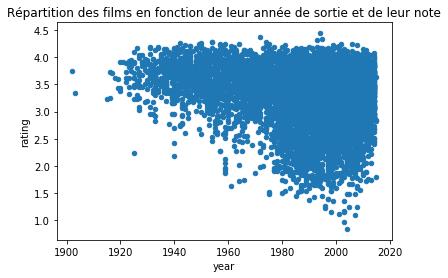

In [71]:
movie_rate_genre.plot.scatter(x='year', y='rating');
plt.title("Répartition des films en fonction de leur année de sortie et de leur note")

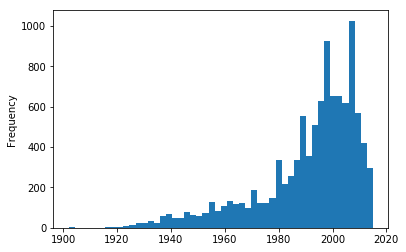

In [40]:
movie_rate_genre.year.plot.hist(bins=50)

On va maintenant regarder pour chaque utilisateur, la moyenne qu'il donne aux films de 1980 à 2000 et la moyenne qu'il donne aux films du debut de ce 21eme siecle.

In [41]:
rating_user_movie = pd.merge(ratings, movies_set)
rating_user_movie.head()

,userId,movieId,rating,timestamp,title,genres
0,1,2,3.5,1112486027,Jumanji (1995),Adventure|Children|Fantasy
1,5,2,3.0,851527569,Jumanji (1995),Adventure|Children|Fantasy
2,13,2,3.0,849082742,Jumanji (1995),Adventure|Children|Fantasy
3,29,2,3.0,835562174,Jumanji (1995),Adventure|Children|Fantasy
4,34,2,3.0,846509384,Jumanji (1995),Adventure|Children|Fantasy


In [42]:
rating_user_movie['year'] = rating_user_movie.title.str.extract("\((\d{4})\)", expand=True)
rating_user_movie.year = pd.to_datetime(rating_user_movie.year, format='%Y')
rating_user_movie.year = rating_user_movie.year.dt.year # As there are some NaN years, resulting type will be float (decimals)
rating_user_movie.title = rating_user_movie.title.str[:-7]

In [43]:
rating_user_movie.sort_values(by=['userId']).head(30)

,userId,movieId,rating,timestamp,title,genres,year
0,1,2,3.5,1112486027,Jumanji,Adventure|Children|Fantasy,1995.0
505014,1,541,4.0,1112484603,Blade Runner,Action|Sci-Fi|Thriller,1982.0
2380423,1,6807,3.5,1112484686,Monty Python's The Meaning of Life,Comedy,1983.0
2378699,1,6774,4.0,1112485786,Videodrome,Fantasy|Horror|Sci-Fi|Thriller,1983.0
2376750,1,6755,3.5,1094786067,Bubba Ho-tep,Comedy|Horror,2002.0
2372550,1,6754,4.0,1112485984,Underworld,Action|Fantasy|Horror,2003.0
535540,1,589,3.5,1112485557,Terminator 2: Judgment Day,Action|Sci-Fi,1991.0
1837151,1,2918,3.5,1112485465,Ferris Bueller's Day Off,Comedy,1986.0
1536213,1,2100,4.0,1112485955,Splash,Comedy|Fantasy|Romance,1984.0
1860468,1,2944,4.0,1112485433,"Dirty Dozen, The",Action|Drama|War,1967.0


In [44]:
mean_by_year_by_user = rating_user_movie.groupby('userId').agg({'rating': np.mean})
#mean_by_year_by_user.head()

In [45]:
liste80=[i for i in range(1980, 2000)]
liste00=[i for i in range(2000, 2020)]

year_rating = pd.DataFrame()

for y in [liste80, liste00]:
    something = rating_user_movie[rating_user_movie['year'].isin(y)]
    mean_decenie = something.loc[:,['userId','rating']].groupby(['userId'])['rating'].mean().round(2)
    year_rating = pd.concat((year_rating, mean_decenie), axis=1)
    


In [46]:
year_rating.columns=["rating_80s_00s","rating_2000s_2020s"]


In [47]:
year_rating.dropna(inplace=True)

In [48]:
year_rating

,rating_80s_00s,rating_2000s_2020s
userId,,
1,3.73,3.90
2,3.81,3.80
7,3.18,3.34
9,2.90,3.00
11,4.02,3.91
14,3.63,4.01
16,3.47,1.00
17,4.00,4.14
18,3.16,3.86


On supprime ici les données des utilisateurs qui ont un avis assez neutre en général pour avoir seulement des avis des utilisateurs avec un avis tranché.

In [49]:
year_rating_trie = year_rating.drop(year_rating[(year_rating['rating_80s_00s'] >= 2.5)  & (year_rating['rating_80s_00s'] <= 3.5)].index)


In [50]:
year_rating_trie = year_rating_trie.drop(year_rating_trie[(year_rating_trie['rating_2000s_2020s'] >= 2.5)  & (year_rating_trie['rating_2000s_2020s'] <= 3.5)].index)


In [51]:
year_rating_trie

,rating_80s_00s,rating_2000s_2020s
userId,,
1,3.73,3.90
2,3.81,3.80
11,4.02,3.91
14,3.63,4.01
17,4.00,4.14
25,3.62,3.62
35,4.02,4.34
42,4.09,4.39
43,3.69,3.70


Automatically created module for IPython interactive environment


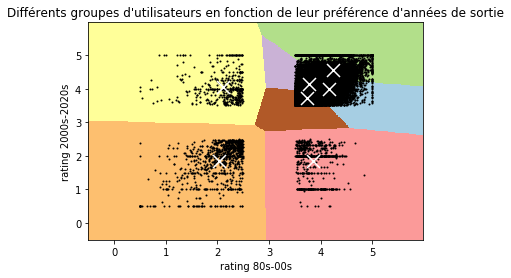

In [72]:
print(__doc__)

from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

data = np.array(year_rating_trie)

n_samples, n_features = data.shape


# #############################################################################
# Visualize the results on PCA-reduced data


kmeans = KMeans(init='k-means++', n_clusters=7, n_init=10)
kmeans.fit(data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(data[:, 0], data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.xlabel("rating 80s-00s")
plt.ylabel("rating 2000s-2020s")
plt.title("Différents groupes d'utilisateurs en fonction de leur préférence d'années de sortie")
plt.show()


In [ ]:
#centroide, matrice = km.kmoyennes(4,movie_rate_genre[["rating","year"]],100)